In [69]:
import pandas as pd
import xgboost as xgb
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve

In [316]:
df_ohe = pd.read_csv('C:\\Users\\jk\Desktop\\data science - infoshare\\projekt_SQL\\jdszr4-edc\\3-projekt-ml\\data_preparation\\dummiefied_df.csv')


# Model dla danych przygotowanych z zastosowaniem one hot encodingu

In [317]:
# train - test split
X_train, X_test, y_train, y_test = train_test_split(
    df_ohe.drop(['class_e', 'class_p'], axis=1),
    df_ohe['class_p'],
    test_size=0.25,
    random_state=1000)

print(X_test.shape)
print(X_train.shape)

#alignment kolumn
X_train.sort_index(axis=1, inplace=True)
X_test.sort_index(axis=1,inplace=True)

(2031, 116)
(6093, 116)


In [319]:
# model
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=50, max_depth=3)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

C:\Users\jk\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:03:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [320]:
#Accuracy

print(f'Accuracy of the xgb model euqals {accuracy_score(y_test, y_pred)}')

Accuracy of the xgb model euqals 1.0


In [321]:
# Raport modelu

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1048
           1       1.00      1.00      1.00       983

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



Text(0, 0.5, 'True positive rate')

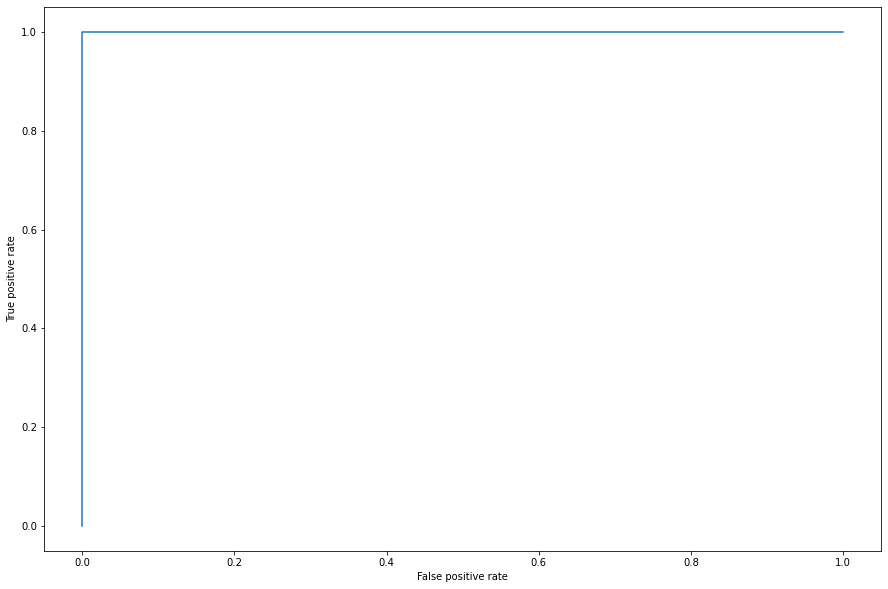

In [322]:
# Receiver operating characteristic
probas = model.predict_proba(X_test)
positive_proba = probas[:, 1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, positive_proba)
plt.figure(figsize=(15, 10))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

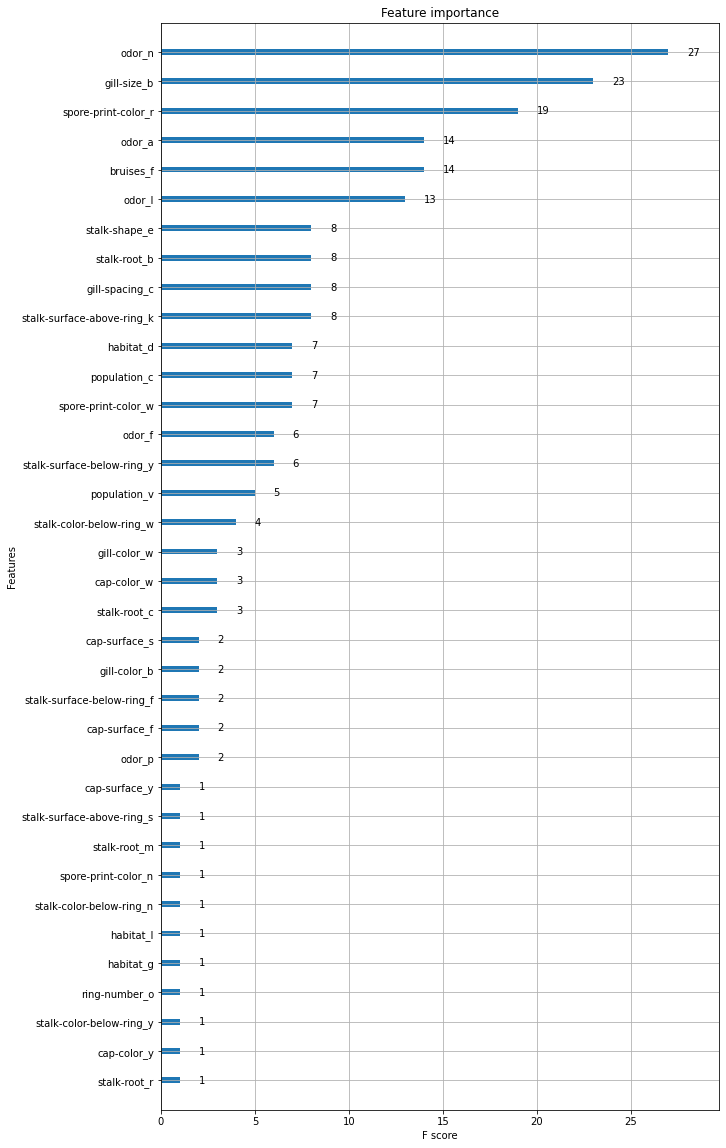

In [323]:
#Feature importance 
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(model, ax=ax)

# Test modelu

In [324]:
def shroom_check(sample, prediction: int, df):
    """
    Function checks if prediction was consistent with the class value from original dataframe.
    """
    
    ix = sample.index[0]
    row_ix = df[df.columns[2:]].iloc[ix:ix+1]
    result = prediction == df.iloc[ix]['class_p']

    return result

In [326]:
s_test = X_test.sample()
s_test

,bruises_f,bruises_t,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,...,stalk-surface-above-ring_s,stalk-surface-above-ring_y,stalk-surface-below-ring_f,stalk-surface-below-ring_k,stalk-surface-below-ring_s,stalk-surface-below-ring_y,veil-color_n,veil-color_o,veil-color_w,veil-color_y
6371,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [327]:
s_test.index[:]

Int64Index([6371], dtype='int64')

In [328]:
prediction = int(model.predict(s_test))
prediction

1

In [329]:
shroom_check(s_test, prediction, df_ohe)

True

In [330]:
def test_prediction(n: int, df, model):
    """
    Function gives results for n iteration of prediction from random samples from dataset.
    """
    
    correct_values = 0
    i = 0
    X = df.copy(deep=False)
    
    for col in X.columns:
        if 'class' in col:
            X.drop(col, axis=1, inplace=True)
    
    while i < n:
        sample = X.sample()
        prediction = int(model.predict(sample))
        check = shroom_check(sample, prediction, df)
    
        if check == True:
            correct_values += 1
        
        i += 1

    print(f'True predictions: {correct_values} ({100 * correct_values / n}%)')
    print(f'False predictions: {n - correct_values} ({100 - 100 * correct_values / n}%)')

In [331]:
test_prediction(100, df_ohe, model)

True predictions: 61 (61.0%)
False predictions: 39 (39.0%)


In [332]:
def get_features(df):
    columns_original = set()
    
    for column in df.columns:
        if column[:-2] in ['class']:
            continue
        columns_original.add(column[:-2])
    
    return list(columns_original)

In [333]:
def get_random_features(df, n_randoms: int):
    
    columns_original = get_features(df)
    
    random_columns = set()
    
    for i in range(n_randoms):
        random_column = columns_original[np.random.randint(0, len(columns_original))]
        random_columns.add(random_column)
        columns_original.remove(random_column)
    
    return random_columns

In [334]:
def copy_df_with_nan_values(df, columns_to_nan = set(), filler = -1):
    """
    Function returns a copy from dataset with n features filled with filler.
    The filler value is set to default as -1.
    """
    
    df_copy = df.copy()
    
    for column in df_copy.columns:
        if column[:-2] in columns_to_nan:
            df_copy[column] = np.NaN
     
    df_copy.fillna(filler, inplace=True)
    
    return df_copy

In [335]:
for col in get_features(df_ohe_var):
    print(f'Results for {col}')
    g = copy_df_with_nan_values(df_ohe_var, set([col]))
    test_prediction(1000, g, model)
    print('\n')

Results for ring-type
True predictions: 633 (63.3%)
False predictions: 367 (36.7%)


Results for cap-color
True predictions: 607 (60.7%)
False predictions: 393 (39.3%)


Results for gill-color
True predictions: 622 (62.2%)
False predictions: 378 (37.8%)


Results for gill-attachment
True predictions: 645 (64.5%)
False predictions: 355 (35.5%)


Results for bruises
True predictions: 653 (65.3%)
False predictions: 347 (34.7%)


Results for gill-spacing
True predictions: 646 (64.6%)
False predictions: 354 (35.400000000000006%)


Results for cap-shape
True predictions: 638 (63.8%)
False predictions: 362 (36.2%)


Results for stalk-surface-below-ring
True predictions: 652 (65.2%)
False predictions: 348 (34.8%)


Results for gill-size
True predictions: 620 (62.0%)
False predictions: 380 (38.0%)


Results for spore-print-color
True predictions: 649 (64.9%)
False predictions: 351 (35.099999999999994%)


Results for population
True predictions: 642 (64.2%)
False predictions: 358 (35.8%)


Resul

In [336]:
import sys

sys.path.append('../..')

In [337]:
import scoring as sc

In [338]:
mh = sc.ModelHandler(model, df_ohe)
mh

In [339]:
mh.predict_for_user_input({'odor': 'l'})

Model score on 2000 samples: 0.5045


{'accuracy': 0.5045, 'poisonous': 1}

In [340]:
mh.predict_for_user_input({'odor': 'n'})

Model score on 2000 samples: 0.487


{'accuracy': 0.487, 'poisonous': 1}

In [343]:
test_model = sc.TestModel(model, df_ohe)
test_model

In [344]:
test_model.test_predictions()

Model score on 100 samples: 0.64


0.64

In [345]:
test_model.test_predictions(n=848)

Model score on 848 samples: 0.6403301886792453


0.6403301886792453

In [346]:
test_model.test_for_empty_feature()

Results for ring-type
Model score on 100 samples: 0.69


Results for cap-color
Model score on 100 samples: 0.69


Results for gill-color
Model score on 100 samples: 0.61


Results for gill-attachment
Model score on 100 samples: 0.56


Results for bruises
Model score on 100 samples: 0.65


Results for gill-spacing
Model score on 100 samples: 0.62


Results for cap-shape
Model score on 100 samples: 0.6


Results for stalk-surface-below-ring
Model score on 100 samples: 0.6


Results for gill-size
Model score on 100 samples: 0.65


Results for spore-print-color
Model score on 100 samples: 0.68


Results for population
Model score on 100 samples: 0.64


Results for stalk-root
Model score on 100 samples: 0.6


Results for stalk-color-below-ring
Model score on 100 samples: 0.6


Results for veil-color
Model score on 100 samples: 0.59


Results for stalk-surface-above-ring
Model score on 100 samples: 0.67


Results for habitat
Model score on 100 samples: 0.59


Results for stalk-shape
Model sc

In [347]:
for i in range(2, 16):
    for j in range(5):
        print(f'Try {j} for {i} features.')
        test_model.test_for_missing_m_features(i, 2000)
        print('\n')

Try 0 for 2 features.
Removed features: {'ring-number', 'cap-color'}
Model score on 2000 samples: 0.6365


Try 1 for 2 features.
Removed features: {'stalk-surface-above-ring', 'stalk-color-below-ring'}
Model score on 2000 samples: 0.6445


Try 2 for 2 features.
Removed features: {'stalk-color-below-ring', 'veil-color'}
Model score on 2000 samples: 0.644


Try 3 for 2 features.
Removed features: {'cap-surface', 'veil-color'}
Model score on 2000 samples: 0.641


Try 4 for 2 features.
Removed features: {'cap-color', 'stalk-color-above-ring'}
Model score on 2000 samples: 0.6355


Try 0 for 3 features.
Removed features: {'gill-spacing', 'stalk-root', 'gill-color'}
Model score on 2000 samples: 0.548


Try 1 for 3 features.
Removed features: {'cap-shape', 'population', 'cap-color'}
Model score on 2000 samples: 0.6445


Try 2 for 3 features.
Removed features: {'gill-attachment', 'gill-size', 'veil-color'}
Model score on 2000 samples: 0.6415


Try 3 for 3 features.
Removed features: {'gill-colo